### Student Information
Name: 黃柏瑀

Student ID: 105062641

In [243]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly.plotly as py
import plotly.graph_objs as go
import math
from gensim.models import word2vec
 

# my functions
import helpers.data_mining_helpers as dmh
import helpers.text_analysis as ta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [245]:
imdb="./dataset/imdb_labelled.txt"
yelp="./dataset/yelp_labelled.txt"
amazon="./dataset/amazon_cells_labelled.txt"
lines = []
# Opening and Reading the files into a list 
for file in [imdb, yelp, amazon]:
    with open(file, "r") as text_file:
        lines += text_file.read().split('\n')
       
# Remove Empty string from list
lines = list(filter(None, lines)) 
lines[:3]

['imdb\tA very, very, very slow-moving, aimless movie about a distressed, drifting young man.  \t0',
 'imdb\tNot sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  \t0',
 'imdb\tAttempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  \t0']

In [246]:
# Separate by tab
lines = [line.split("\t") for line in lines if len(line.split("\t"))==3 and line.split("\t")[2]!='']
lines[:3]

[['imdb',
  'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ',
  '0'],
 ['imdb',
  'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  ',
  '0'],
 ['imdb',
  'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  ',
  '0']]

# Converting Dictionary into Pandas dataframe

In [247]:
# Create dataframe
dataset = pd.DataFrame(lines, columns=['source', 'sentence', 'label'])
dataset[:10]
#dataset.to_csv('./dataset/Sentiment_Labelled_Sentences_Data_Set.csv', index=False)

,source,sentence,label
0,imdb,"A very, very, very slow-moving, aimless movie ...",0
1,imdb,Not sure who was more lost - the flat characte...,0
2,imdb,Attempting artiness with black & white and cle...,0
3,imdb,Very little music or anything to speak of.,0
4,imdb,The best scene in the movie was when Gerardo i...,1
5,imdb,"The rest of the movie lacks art, charm, meanin...",0
6,imdb,Wasted two hours.,0
7,imdb,Saw the movie today and thought it was a good ...,1
8,imdb,A bit predictable.,0
9,imdb,Loved the casting of Jimmy Buffet as the scien...,1


In [248]:
semanticDF = pd.read_csv('./dataset/Sentiment_Labelled_Sentences_Data_Set.csv')
semanticDF[:10][['source', 'sentence']]

,source,sentence
0,imdb,"A very, very, very slow-moving, aimless movie ..."
1,imdb,Not sure who was more lost - the flat characte...
2,imdb,Attempting artiness with black & white and cle...
3,imdb,Very little music or anything to speak of.
4,imdb,The best scene in the movie was when Gerardo i...
5,imdb,"The rest of the movie lacks art, charm, meanin..."
6,imdb,Wasted two hours.
7,imdb,Saw the movie today and thought it was a good ...
8,imdb,A bit predictable.
9,imdb,Loved the casting of Jimmy Buffet as the scien...


# Deal with Missing Values

In [249]:
# Determine the return type and shape of Dataframe.isnull()
print(type(semanticDF.isnull()), semanticDF.isnull().shape)

# Check missing values
semanticDF.isnull().apply(lambda x: dmh.check_missing_values(x))

<class 'pandas.core.frame.DataFrame'> (3000, 3)


source      (The amoung of missing records is: , 0)
sentence    (The amoung of missing records is: , 0)
label       (The amoung of missing records is: , 0)
dtype: object

## Manually insert missing values

In [250]:
# Make a copy and play around
defectDF = semanticDF.copy(deep=True)

# Let first 5 entries to be all NaN
defectDF.iloc[0:5,0:3] = pd.np.nan

In [251]:
defectDF[0:10]

,source,sentence,label
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,imdb,"The rest of the movie lacks art, charm, meanin...",0.0
6,imdb,Wasted two hours.,0.0
7,imdb,Saw the movie today and thought it was a good ...,1.0
8,imdb,A bit predictable.,0.0
9,imdb,Loved the casting of Jimmy Buffet as the scien...,1.0


In [252]:
# Check missing values in each column(index)
defectDF.isnull().apply(lambda x: dmh.check_missing_values(x), axis=0)

source      (The amoung of missing records is: , 5)
sentence    (The amoung of missing records is: , 5)
label       (The amoung of missing records is: , 5)
dtype: object

In [253]:
# Check missing values in row-wise
defectDF[0:10].isnull().apply(lambda x: dmh.check_missing_values(x), axis=1)

0    (The amoung of missing records is: , 3)
1    (The amoung of missing records is: , 3)
2    (The amoung of missing records is: , 3)
3    (The amoung of missing records is: , 3)
4    (The amoung of missing records is: , 3)
5    (The amoung of missing records is: , 0)
6    (The amoung of missing records is: , 0)
7    (The amoung of missing records is: , 0)
8    (The amoung of missing records is: , 0)
9    (The amoung of missing records is: , 0)
dtype: object

## Add dummy data

In [254]:
dummyDF = semanticDF.copy(deep=True)
dummy_series = pd.Series(["dummy", pd.np.nan, 0], index=["source", "sentence", "label"])

for i in range(0,5):
    dummyDF = dummyDF.append(dummy_series,ignore_index=True).reset_index(drop=True)

print(len(dummyDF))

# Show last 10 record
dummyDF[-10:]

3005


,source,sentence,label
2995,amazon,The screen does get smudged easily because it ...,0
2996,amazon,What a piece of junk.. I lose more calls on th...,0
2997,amazon,Item Does Not Match Picture.,0
2998,amazon,The only thing that disappoint me is the infra...,0
2999,amazon,"You can not answer calls with the unit, never ...",0
3000,dummy,NaN,0
3001,dummy,NaN,0
3002,dummy,NaN,0
3003,dummy,NaN,0
3004,dummy,NaN,0


In [255]:
# Check missing values, and find 5 missing values
dummyDF.isnull().apply(lambda x: dmh.check_missing_values(x), axis=0)

source      (The amoung of missing records is: , 0)
sentence    (The amoung of missing records is: , 5)
label       (The amoung of missing records is: , 0)
dtype: object

In [256]:
# Drop them !
len_b = len(dummyDF)
dummyDF.dropna(inplace=True)
len_a = len(dummyDF)
dummyDF.isnull().apply(lambda x: dmh.check_missing_values(x), axis=0)

source      (The amoung of missing records is: , 0)
sentence    (The amoung of missing records is: , 0)
label       (The amoung of missing records is: , 0)
dtype: object

In [257]:
print("Before dropping:", len_b)
print("After dropping:", len_a)

Before dropping: 3005
After dropping: 3000


# 4. Dealing with Duplicate Data

In [258]:
# Checkout if duplicated record
print("duplicated record: "+str(sum(semanticDF.duplicated(keep=False))))
print(semanticDF.shape)

# Remove them
semanticDF = semanticDF.drop_duplicates()
print("duplicated record: "+str(sum(semanticDF.duplicated(keep=False))))
print(semanticDF.shape) 

# We can observe that 17 duplicated records been eliminated!

duplicated record: 34
(3000, 3)
duplicated record: 0
(2983, 3)


# 5. Data Processing

## 5.1 Sampling

In [259]:
sampleDF = semanticDF.copy(deep=True)
sampleDF = sampleDF.sample(n=1000)

print("type fo sampleDF is ",type(sampleDF))
print(len(sampleDF))

type fo sampleDF is  <class 'pandas.core.frame.DataFrame'>
1000


In [260]:
X_category_counts = ta.get_tokens_and_frequency(list(semanticDF.source))
X_sample_category_counts = ta.get_tokens_and_frequency(list(sampleDF.source))

In [269]:
word_dict = X_category_counts

In [384]:
py.iplot(ta.plot_word_frequency(X_category_counts,  "Original data's Category distribution"))

'file:///home/jordan/working/data_mining_hw_1/temp-plot.html'

In [383]:
py.iplot(ta.plot_word_frequency(X_sample_category_counts, "Sampled data's Category distribution"))

In [300]:
# Let's visualize them together
# [Ref] https://plot.ly/python/bar-charts/#grouped-bar-chart-with-direct-labels
py.iplot(ta.plot_compared_word_frequency(X_sample_category_counts, X_category_counts, "[Original vs sampled] data's Category distribution"))

# 5. Features creation

In [323]:
# Create unigrams
semanticDF['Unigrams'] = semanticDF['sentence'].apply(lambda x: dmh.tokenize_text(x.lower()))

In [324]:
semanticDF['Unigrams'][0:4]

0    [a, very, ,, very, ,, very, slow-moving, ,, ai...
1    [not, sure, who, was, more, lost, -, the, flat...
2    [attempting, artiness, with, black, &, white, ...
3    [very, little, music, or, anything, to, speak,...
Name: Unigrams, dtype: object

In [325]:
# Tokenize a unigrams
list(semanticDF[1:2]['Unigrams'])

[['not',
  'sure',
  'who',
  'was',
  'more',
  'lost',
  '-',
  'the',
  'flat',
  'characters',
  'or',
  'the',
  'audience',
  ',',
  'nearly',
  'half',
  'of',
  'whom',
  'walked',
  'out',
  '.']]

In [326]:
# Create unigrams, with stopword been removed!
semanticDF['Unigrams'] = semanticDF['sentence'].apply(lambda x: dmh.tokenize_text(x.lower(), remove_stopwords=True))

# Tokenize a unigrams
list(semanticDF[1:2]['Unigrams'])

[['sure',
  'lost',
  '-',
  'flat',
  'characters',
  'audience',
  ',',
  'nearly',
  'half',
  'walked',
  '.']]

In [342]:
# tag each token with 詞性
tagged = []
for word in semanticDF.Unigrams:
    tagged += nltk.pos_tag(word)

In [343]:
# Extract noun word
noun = [word for word,pos in tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
noun

['movie',
 'man',
 'sure',
 'characters',
 'audience',
 'clever',
 'camera',
 'angles',
 'movie',
 'plot',
 'lines',
 'music',
 'anything',
 'speak',
 'scene',
 'movie',
 'gerardo',
 'find',
 'keeps',
 'head',
 'rest',
 'movie',
 'charm',
 'emptiness',
 'guess',
 'empty',
 'hours',
 'saw',
 'movie',
 'today',
 'effort',
 'messages',
 'kids',
 'bit',
 'jimmy',
 'buffet',
 'science',
 'teacher',
 'baby',
 'movie',
 'lot',
 'florida',
 'look',
 'appealing',
 'songs',
 'muppets',
 'cool',
 'case',
 'movie',
 'delivers',
 'everything',
 'face',
 'person',
 'budget',
 'see',
 'review',
 'tale',
 'sisters',
 'film',
 'movie',
 'terms',
 'cinematography',
 'post-production',
 'film-making',
 '\x96',
 'masterpiece',
 'sea',
 'masterpieces',
 'structure',
 'film',
 'history',
 'cinema',
 'think',
 'film',
 'something',
 'occurs',
 'minute',
 'words',
 'level',
 'film',
 'dozen',
 'films',
 'anyone',
 'mind',
 'anything',
 'movie',
 'form',
 'cinema',
 'film',
 'amount',
 'puzzle-solving',
 'piec

In [344]:
print(len(tagged), len(noun))

24025 8205


## 5.3 Feature subset selection

In [328]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(semanticDF.sentence)

In [330]:
analyze = count_vect.build_analyzer()
analyze(" ".join(list(semanticDF[4:5].sentence)))

['the',
 'best',
 'scene',
 'in',
 'the',
 'movie',
 'was',
 'when',
 'gerardo',
 'is',
 'trying',
 'to',
 'find',
 'song',
 'that',
 'keeps',
 'running',
 'through',
 'his',
 'head']

In [345]:
# shape of this matrix:
X_counts.shape

(2983, 5155)

In [346]:
" ".join(list(semanticDF[4:5].sentence))

'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  '

In [350]:
# We can obtain the feature names of the vectorizer, i.e., the terms
count_vect.get_feature_names()[0:-1:20]

['00',
 '1986',
 '3o',
 '80s',
 'absolutely',
 'accomodate',
 'activated',
 'admiration',
 'ages',
 'allergy',
 'amazed',
 'angeles',
 'anti',
 'appears',
 'armageddon',
 'ask',
 'att',
 'auto',
 'baaaaaad',
 'balance',
 'baseball',
 'beat',
 'begin',
 'bend',
 'biographical',
 'blandest',
 'bmw',
 'boost',
 'bowl',
 'brian',
 'brunch',
 'built',
 'buttons',
 'calendar',
 'candace',
 'carly',
 'cassette',
 'cellphones',
 'channel',
 'cheap',
 'chewy',
 'choices',
 'classic',
 'close',
 'collect',
 'comforting',
 'compelling',
 'concentrate',
 'connect',
 'constantly',
 'contract',
 'cooking',
 'could',
 'cox',
 'crazy',
 'critical',
 'cumbersome',
 'damage',
 'deaf',
 'dedicated',
 'delicioso',
 'derivative',
 'despite',
 'dialog',
 'dipping',
 'disaster',
 'display',
 'doctor',
 'dosen',
 'drain',
 'drift',
 'due',
 'each',
 'eat',
 'effects',
 'else',
 'empty',
 'enough',
 'ericson',
 'even',
 'exceeding',
 'excuses',
 'explains',
 'fabulous',
 'falwell',
 'faster',
 'fell',
 'fillet

In [355]:
type(X_counts)

scipy.sparse.csr.csr_matrix

In [357]:
semanticDF[0:5].sentence

0    A very, very, very slow-moving, aimless movie ...
1    Not sure who was more lost - the flat characte...
2    Attempting artiness with black & white and cle...
3         Very little music or anything to speak of.  
4    The best scene in the movie was when Gerardo i...
Name: sentence, dtype: object

In [359]:
X_counts[0:5, 0:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [362]:
a = count_vect.transform(['Something completely new.']).toarray()
print(a, a.shape)

[[0 0 0 ..., 0 0 0]] (1, 5155)


In [369]:
a = count_vect.transform(['00 23 accessable']).toarray()
print(a,  a.sum()) # 3 token are presented in a
count_vect.get_feature_names()[0:100:10]

[[1 0 0 ..., 0 0 0]] (1, 5155) 3


['00',
 '18',
 '1986',
 '23',
 '3o',
 '510',
 '80s',
 'abandoned',
 'absolutely',
 'accessable']

In [379]:
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names()[0:-1:10]]
plot_y = ["sent_"+ str(i) for i in list(semanticDF.index)[0:-1:10]]
plot_z = X_counts[0:-1:10, 0:-1:10].toarray()
py.iplot(ta.plot_heat_map(plot_x, plot_y, plot_z))

## 5.4 Dimensionality Reduction

In [391]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=5).fit_transform(X_counts.toarray())
X_reduced.shape

(2983, 5)

In [392]:
trace1 = ta.get_trace(X_reduced, semanticDF["source"], "amazon", "rgb(71,233,163)")
trace2 = ta.get_trace(X_reduced, semanticDF["source"], "imdb", "rgb(52,133,252)")
trace3 = ta.get_trace(X_reduced, semanticDF["source"], "yelp", "rgb(229,65,136)")
data = [trace1, trace2, trace3]

In [393]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

## 5.5 Atrribute Transformation / Aggregation

In [416]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
# term_frequencies = [sum(X_counts[:,j].toarray()) for j in range(0, X_counts.shape[1])]

# Faster way to sum up
term_frequencies = [X_counts[:,j].toarray().sum() for j in range(0, X_counts.shape[1])]

In [419]:
# OrderedDict
from collections import OrderedDict

term_name_and_freq = OrderedDict(zip(count_vect.get_feature_names(), term_frequencies))
term_name_and_freq

OrderedDict([('00', 1),
             ('10', 36),
             ('100', 3),
             ('11', 2),
             ('12', 4),
             ('13', 3),
             ('15', 3),
             ('15g', 1),
             ('15pm', 1),
             ('17', 2),
             ('18', 1),
             ('18th', 1),
             ('1928', 1),
             ('1947', 1),
             ('1948', 1),
             ('1949', 1),
             ('1971', 1),
             ('1973', 1),
             ('1979', 1),
             ('1980', 1),
             ('1986', 1),
             ('1995', 1),
             ('1998', 1),
             ('20', 9),
             ('2000', 1),
             ('2005', 2),
             ('2006', 1),
             ('2007', 1),
             ('20th', 2),
             ('2160', 1),
             ('23', 1),
             ('24', 1),
             ('25', 2),
             ('2mp', 1),
             ('30', 7),
             ('30s', 1),
             ('325', 1),
             ('35', 3),
             ('350', 1),
             ('375'

In [421]:
py.iplot(ta.plot_word_frequency(term_name_and_freq, "Term Frequency Distribution"))

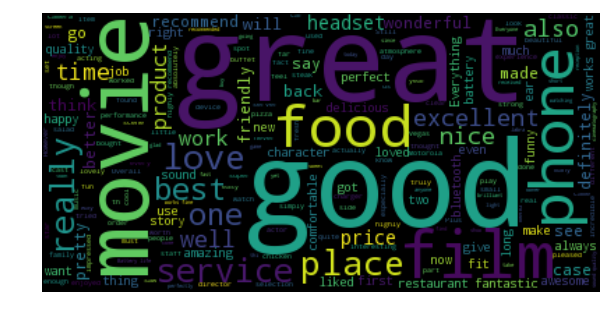

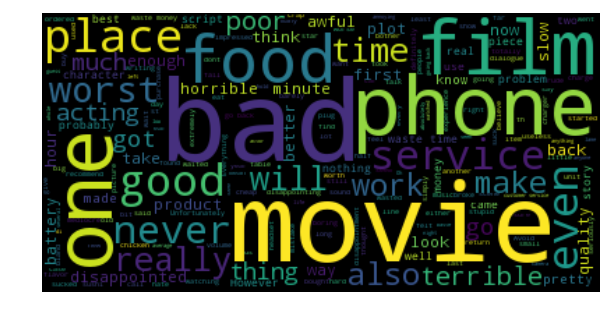

In [264]:
postive_sentence = (semanticDF['sentence'][semanticDF['label'] == 1])
negative_sentence = semanticDF['sentence'][semanticDF['label'] == 0]

ta.plot_word_cloud(postive_sentence.to_string())
ta.plot_word_cloud(negative_sentence.to_string())

In [319]:
from nltk.corpus import stopwords
stopWord = stopwords.words('english')
#print(type(stopWord))
p_token = []
n_token = []

for sentence in postive_sentence:
    p_token += dmh.tokenize_text(sentence.lower())
    
for sentence in negative_sentence:
    n_token += dmh.tokenize_text(sentence.lower())

# Remove stop word
p_token = [x for x in p_token if x not in stopWord ]
n_token = [x for x in n_token if x not in stopWord ]

# tag each token with 詞性
p_tagged = nltk.pos_tag(p_token)
n_tagged = nltk.pos_tag(n_token)

# Focus on only on "noun words"
p_nouns = [word for word,pos in p_tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
n_nouns = [word for word,pos in n_tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

p_token_dict = ta.get_tokens_and_frequency(p_nouns)
n_token_dict = ta.get_tokens_and_frequency(n_nouns)

<class 'list'>
<class 'nltk.corpus.reader.wordlist.WordListCorpusReader'>


TypeError: argument of type 'WordListCorpusReader' is not iterable

In [266]:
#for key, value in p_token_dict.items():
#    print(key, value)
py.iplot(ta.plot_word_frequency([list(p_token_dict.keys())[0:30], list(p_token_dict.values())[0:30]], "Postive sentence's word freqency"))

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
py.iplot(ta.plot_word_frequency([list(n_token_dict.keys())[0:30], list(n_token_dict.values())[0:30]], "Negative sentence's word freqency"))

In [ ]:
list(postive_sentence)

---

### Instructions

- Download the dataset provided in this [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The sentiment dataset contains a `sentence` and `score` label. Read what the dataset is about on the link provided before you start exploring it. 


- Then, you are asked to apply each of the data exploration and data operation techniques learned in the [first lab session](https://goo.gl/Sg4FS1) on the new dataset. You don't need to explain all the procedures as we did in the notebook, but you are expected to provide some **minimal comments** explaining your code. You are also expected to use the same libraries used in the first lab session. You are allowed to use and modify the `helper` functions we provided in the first lab session or create your own. Also, be aware that the helper functions may need modification as you are dealing with a completely different dataset. This part is worth 80% of your grade!


- After you have completed the operations, you should attempt the **bonus exercises** provided in the [notebook](https://goo.gl/Sg4FS1) we used for the first lab session. There are six (6) additional exercises; attempt them all, as it is part of your grade (10%). 


- You are also expected to tidy up your notebook and attempt new data operations that you have learned so far in the Data Mining course. Surprise us! This segment is worth 10% of your grade.


- After completing all the above tasks, you are free to remove this header block and submit your assignment following the guide provided in the `README.md` file of the assignment's [repository](https://github.com/omarsar/data_mining_hw_1). 